# Daily aggregated values

For daily lightning time series it would be useful to add: 

 - total flash count
 - maximum CG flash density
 - location of maximum flash density (lat lon) and perhaps
 - area exceeding several CG flash density thresholds (0.5, 1 and 2 CG strikes / km2)
 

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import xarray as xr
from scipy.ndimage.filters import gaussian_filter
import seaborn.apionly as sns
from cartopy.io.img_tiles import StamenTerrain
from pointprocess import *
from lightning_setup import *

In [2]:
city = 'cedar'
c = Region(city=cities[city])
c.define_grid()

In [3]:
top10 = c.get_top(10)
top10

2014-09-26 12:00:00    91884
2014-09-27 12:00:00    90627
2015-08-30 12:00:00    66916
2014-08-12 12:00:00    65613
2015-07-08 12:00:00    63068
2015-07-01 12:00:00    62599
2013-08-17 12:00:00    62191
2014-08-26 12:00:00    58833
2014-07-15 12:00:00    50065
2015-08-07 12:00:00    48051
dtype: int64

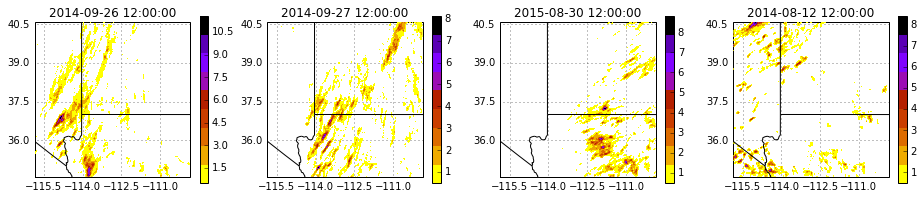

In [4]:
plt.figure(figsize=(16, 3))
for n in range(1,5):    
    ax = background(plt.subplot(1, 4, n, projection=ccrs.PlateCarree()))
    ds0 = c.get_daily_ds(top10.index[n-1],func='grid')
    ds0.close()
    c.plot_grid(gaussian_filter(c.FC_grid,2), cmap=cmap, vmin=.5, cbar=True, ax=ax)
    ax.set_title(top10.index[n-1])

## Total flash count for a given day

In [12]:
c.get_daily_ds('2014-09-26 12:00:00', func='count')

91884

In [15]:
# or equivalently
c.get_daily_ds('2014-09-26 12:00:00', func='grid')
c.FC_grid.sum()

91884.0

## Max daily flash count per grid cell

In [13]:
c.get_daily_ds('2014-09-26 12:00:00', func='max')

23.0

In [14]:
# or equivalently
c.FC_grid.max()

23.0

## Area over threshold

In [17]:
c.area_over_thresh([1,2,5,10, 20])

Area exceeding 1 strikes: 47103 km^2
Area exceeding 2 strikes: 20153 km^2
Area exceeding 5 strikes: 3191 km^2
Area exceeding 10 strikes: 397 km^2
Area exceeding 20 strikes: 7 km^2


## Location of maximum

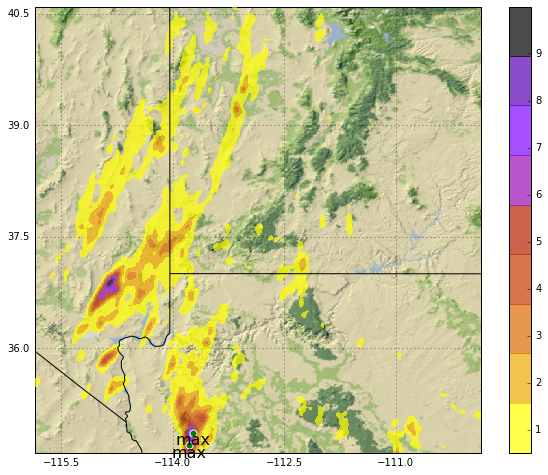

In [21]:
#location of maximum flash density (lat lon)
yy, xx= np.where(c.FC_grid==c.FC_grid.max())
locmax = c.gridx[xx], c.gridy[yy]

plt.figure(figsize=(10,8))
im, ax = c.plot_grid(gaussian_filter(c.FC_grid, 3), cmap=cmap, vmin=.5, cbar=True, alpha=.7)
ax.add_image(StamenTerrain(), 7)
ax.scatter(locmax[0], locmax[1], c='g', s=50, edgecolor='white', zorder=11)
for lon, lat in zip(locmax[0], locmax[1]):
    ax.text(lon, lat, 'max', zorder=12, horizontalalignment='center',
            verticalalignment='top', fontsize=16);

## Make summary files

In [22]:
import os
files = os.listdir(c.PATH)
files.sort()
files[0], files[-1]

('1991_02_08.nc', '2015_09_29.nc')

In [137]:
tr = []
counts = []
maxs = []
area_over_thresh = []
thresh = [1, 2, 3, 5, 8]
k=0
for t in pd.date_range('1991-02-08', '2015-09-29'): 
    c.get_daily_ds(t, func='grid', filter_CG=(0,20))
    maxs.append(c.FC_grid.max())
    counts.append(c.FC_grid.sum())
    area_over_thresh.append([(c.FC_grid >= n).sum() for n in thresh])
    tr.append(t)
    k+=1
    if k%400==0:
        print t

data = np.concatenate([np.array([counts, maxs]).T, np.array(area_over_thresh)], axis=1)
columns=['total_flash_count', 'max_flash_density']
columns.extend(['area_over_{thr}'.format(thr=thr) for thr in thresh])
df = pd.DataFrame(data, index=tr, columns=columns)

df  = df.fillna(0)
df['total_flash_count'] = df['total_flash_count'].astype(int)
df['max_flash_density'] = df['max_flash_density'].astype(int)

computed = pd.HDFStore('computed.h5')
computed['{c}_daily_12UTCto12UTC_filtered'.format(c=city)] = df
computed.close()

1992-03-13 00:00:00
1993-04-17 00:00:00
1994-05-22 00:00:00
1995-06-26 00:00:00
1996-07-30 00:00:00
1997-09-03 00:00:00
1998-10-08 00:00:00
1999-11-12 00:00:00
2000-12-16 00:00:00
2002-01-20 00:00:00
2003-02-24 00:00:00
2004-03-30 00:00:00
2005-05-04 00:00:00
2006-06-08 00:00:00
2007-07-13 00:00:00
2008-08-16 00:00:00
2009-09-20 00:00:00
2010-10-25 00:00:00
2011-11-29 00:00:00
2013-01-02 00:00:00
2014-02-06 00:00:00
2015-03-13 00:00:00


In [19]:
computed = pd.HDFStore('computed.h5')
df = computed['{c}_daily_12UTCto12UTC_filtered'.format(c=city)]
computed.close()

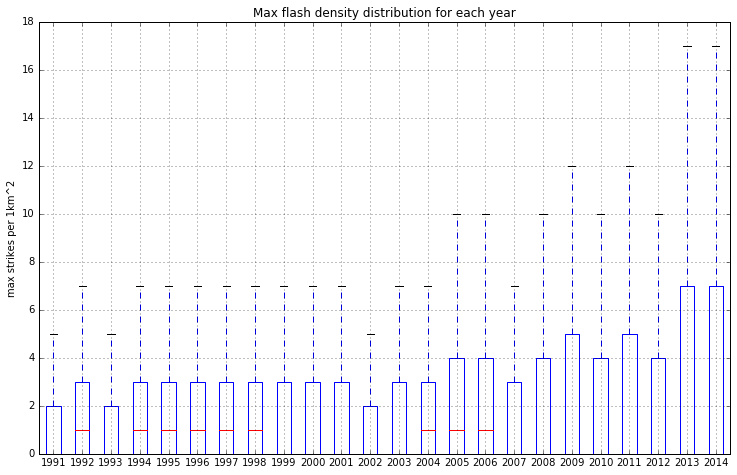

In [121]:
df['1991':'2014'].boxplot(column='max_flash_density', by=df['1991':'2014'].index.year, sym='', figsize=(12,8))
plt.xlabel('')
plt.ylabel('max strikes per 1km^2')
plt.suptitle('')
plt.title('Max flash density distribution for each year')

In [108]:
pv = pd.pivot_table(df, values ='max_flash_density', columns=df.index.year, index=df.index.dayofyear)

(0, 50)

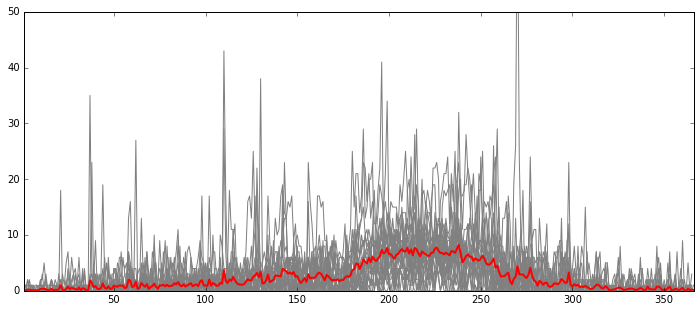

In [119]:
pv.plot(figsize=(12,5), legend=False, color='gray')

# plot the data that has been averaged across years
pv.mean(axis=1).plot(linewidth=2, color='red')
plt.ylim(0,50);

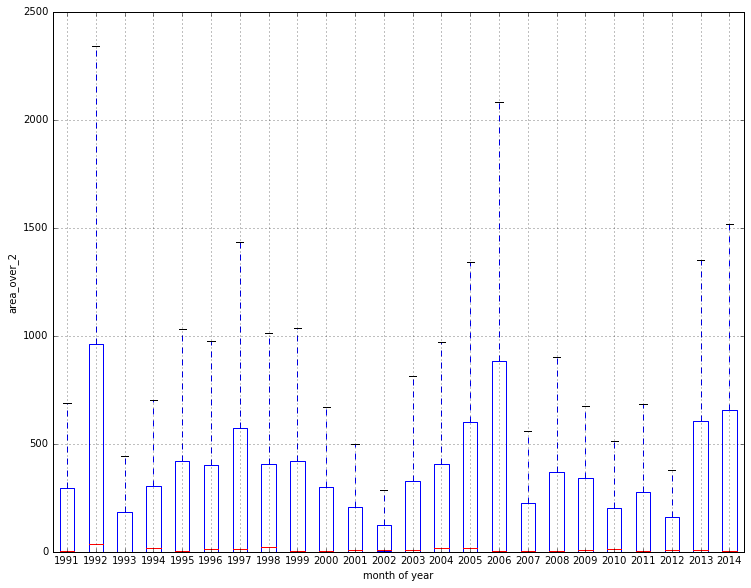

In [52]:
df['1991':'2014'].boxplot(column='area_over_1', by=df['1991':'2014'].index.year, sym='', figsize=(12,10))
plt.xlabel('month of year')
plt.ylabel('')
plt.suptitle('')
plt.title('')

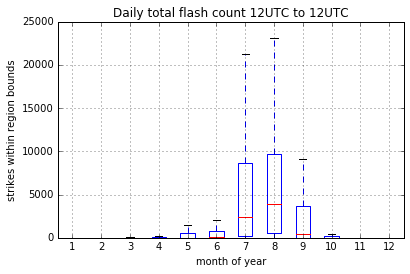

In [48]:
title = 'Daily total flash count 12UTC to 12UTC'

df.boxplot(column='total_flash_count', by=df.index.month, sym='')
plt.xlabel('month of year')
plt.ylabel('strikes within region bounds')
plt.suptitle('')
plt.title(title)
plt.savefig('output/{c}/{title}.png'.format(c=city, title=title))

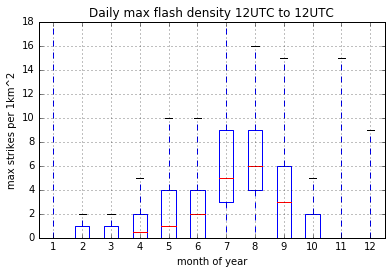

In [47]:
title = 'Daily max flash density 12UTC to 12UTC'

df.boxplot(column='max_flash_density', by=df.index.month, sym='')
plt.xlabel('month of year')
plt.ylabel('max strikes per 1km^2')
plt.title(title)
plt.suptitle('')
plt.savefig('output/{c}/{title}.png'.format(c=city, title=title))

In [27]:
thresh = [1, 2, 3, 5, 8]

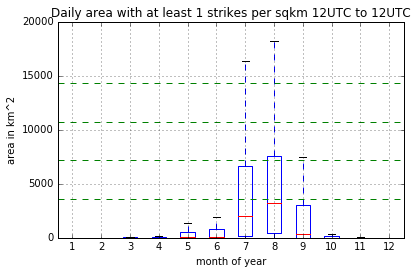

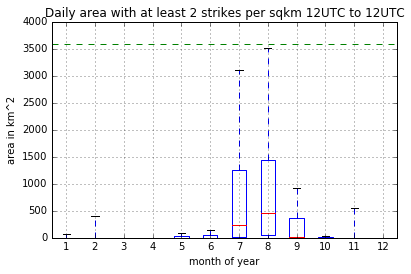

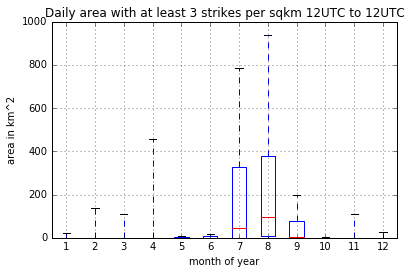

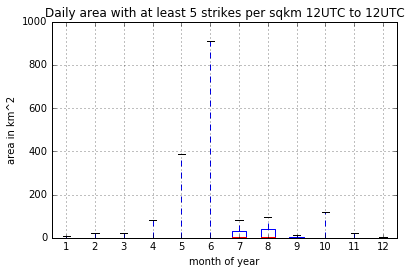

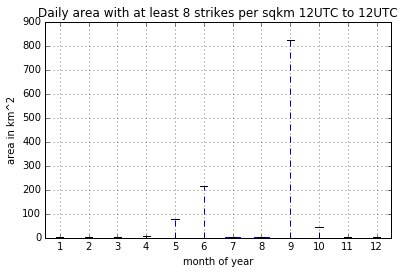

In [28]:
for j in thresh:
    title = 'Daily area with at least {j} strikes per sqkm 12UTC to 12UTC'.format(j=j)

    df.boxplot(column='area_over_{j}'.format(j=j), by=df.index.month, sym='')
    plt.xlabel('month of year')
    plt.ylabel('area in km^2')
    plt.suptitle('')
    #plt.yscale('log')
    n=1
    y = n*599*599/100.
    while y<df['area_over_{j}'.format(j=j)].describe(percentiles=[.99])['99%']:
        plt.axhline(y=y, c='green', linestyle='dashed')
        n+=1
        y=n*599*599/100.
    plt.title(title)
    plt.savefig('output/{c}/{title}.png'.format(c=city, title=title))